# Importing Relevant Libraries

In [ ]:
!pip3 install -r requirements.txt

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel, SelectKBest,mutual_info_classif,chi2,RFECV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,recall_score,precision_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import xgboost
import scikitplot as skplt
from prettytable import PrettyTable
import warnings
warnings.filterwarnings('ignore')

# (1) Data Pre-processing and exploratory analysis

In [ ]:
data = pd.read_csv("data.csv")

In [ ]:
data.shape

(6012, 144)

In [ ]:
data.head()

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,B_avg_KD,B_avg_opp_KD,...,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Adrian Yanez,Gustavo Lopez,Chris Tognoni,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Bantamweight,0.000,0.0,...,0,1,0,0,Orthodox,170.18,177.80,135.0,31.0,27.0
1,Trevin Giles,Roman Dolidze,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Middleweight,0.500,0.0,...,0,3,0,0,Orthodox,182.88,187.96,185.0,32.0,28.0
2,Tai Tuivasa,Harry Hunsucker,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Heavyweight,NaN,NaN,...,1,3,0,0,Southpaw,187.96,190.50,264.0,32.0,28.0
3,Cheyanne Buys,Montserrat Conejo,Mark Smith,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,WomenStrawweight,NaN,NaN,...,0,0,0,0,Switch,160.02,160.02,115.0,28.0,25.0
4,Marion Reneau,Macy Chiasson,Mark Smith,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,WomenBantamweight,0.125,0.0,...,1,2,2,0,Orthodox,167.64,172.72,135.0,29.0,43.0


## (1.1) Removing columns that are unique identifiers

We can clearly see that columns which are unique identifiers such as the R_figher, B_fighter,referee, date and location should be removed for generalisability of the model since they are just identifiers.

In [ ]:
columns_to_drop = ["R_fighter","B_fighter","Referee","date","location"]
data = data.drop(columns=columns_to_drop)

## (1.2) Dealing with NaN values

We can also see that there are some NaN values present.<br>
We are going to see what percentage of the dataset contains these NaN values <br>

In [ ]:
number_of_nan_values = data.isna().any(axis=1).sum()
print(f"The number of rows containing a NaN value is: {number_of_nan_values}")
number_of_datapoints = np.shape(data)[0]
print(f"The number of rows in total is: {number_of_datapoints}")
percentage_of_data_missing_values = number_of_nan_values/number_of_datapoints
print(f"The percentage of the dataset that contains null values is: {percentage_of_data_missing_values*100} %")

The number of rows containing a NaN value is: 2098
The number of rows in total is: 6012
The percentage of the dataset that contains null values is: 34.89687292082502 %


### Finding all the columns which contain NaN values

In [ ]:
for column in data.columns:
    if data[column].isnull().sum()!=0:
        print(f"Number of NaN's in {column}: {data[column].isnull().sum()}")

Number of NaN's in B_avg_KD: 1427
Number of NaN's in B_avg_opp_KD: 1427
Number of NaN's in B_avg_SIG_STR_pct: 1427
Number of NaN's in B_avg_opp_SIG_STR_pct: 1427
Number of NaN's in B_avg_TD_pct: 1427
Number of NaN's in B_avg_opp_TD_pct: 1427
Number of NaN's in B_avg_SUB_ATT: 1427
Number of NaN's in B_avg_opp_SUB_ATT: 1427
Number of NaN's in B_avg_REV: 1427
Number of NaN's in B_avg_opp_REV: 1427
Number of NaN's in B_avg_SIG_STR_att: 1427
Number of NaN's in B_avg_SIG_STR_landed: 1427
Number of NaN's in B_avg_opp_SIG_STR_att: 1427
Number of NaN's in B_avg_opp_SIG_STR_landed: 1427
Number of NaN's in B_avg_TOTAL_STR_att: 1427
Number of NaN's in B_avg_TOTAL_STR_landed: 1427
Number of NaN's in B_avg_opp_TOTAL_STR_att: 1427
Number of NaN's in B_avg_opp_TOTAL_STR_landed: 1427
Number of NaN's in B_avg_TD_att: 1427
Number of NaN's in B_avg_TD_landed: 1427
Number of NaN's in B_avg_opp_TD_att: 1427
Number of NaN's in B_avg_opp_TD_landed: 1427
Number of NaN's in B_avg_HEAD_att: 1427
Number of NaN's 

### Looking at the relationship between reach and height in order to fill in these missing values

#### Red Corner

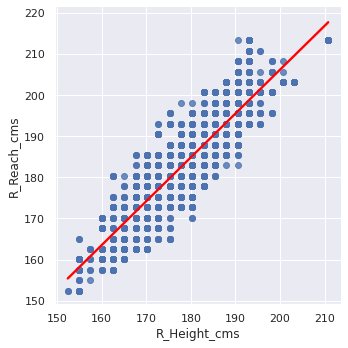

In [ ]:
sns.lmplot(x = 'R_Height_cms', y = 'R_Reach_cms', data=data, fit_reg=True,line_kws={'color': 'red'} ) 
plt.show()

#### Blue Corner

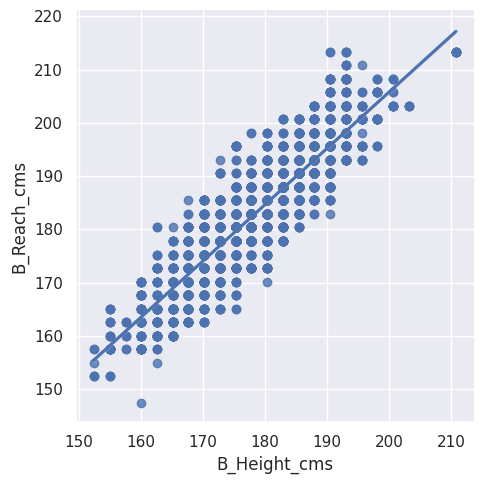

In [ ]:
sns.lmplot(x = 'B_Height_cms', y = 'B_Reach_cms', data=data, fit_reg=True) 
plt.show()

- We see the correlation between a fighters height and their reach, so we can use the height to fill in the missing values in the reach column.

In [ ]:
data['R_Reach_cms'].fillna(data['R_Height_cms'], inplace=True)
data['B_Reach_cms'].fillna(data['B_Height_cms'], inplace=True)
# data.fillna(data.median(), inplace=True)

### Looking at the stance columns, any missing values will be replaced by simply using the most common stance (mode).

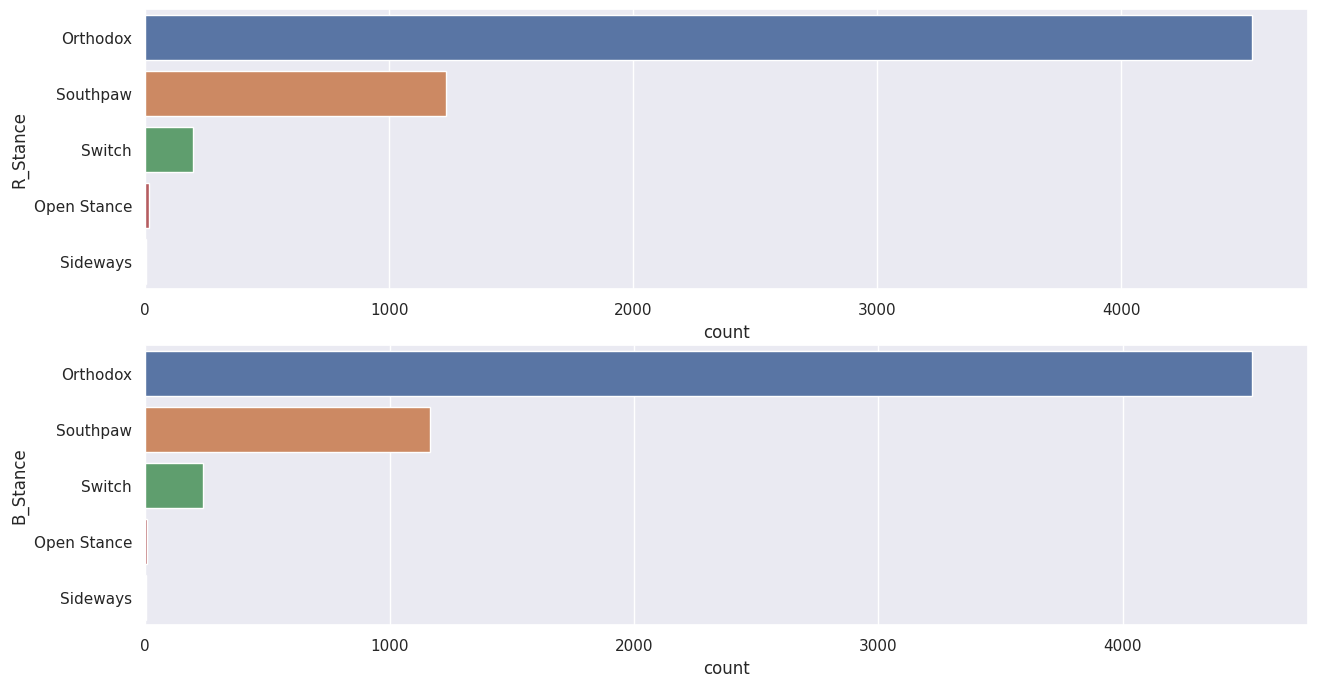

In [ ]:
fig,ax = plt.subplots(nrows = 2, figsize=(15,8))
sns.countplot(y=data['R_Stance'],ax=ax[0])
sns.countplot(y=data['B_Stance'],ax=ax[1])

sns.set()
sns.set(style="white")
plt.show()

We are using the mode which will be Orthodox for both columns

In [ ]:
data['R_Stance'].fillna(data['R_Stance'].mode()[0], inplace=True)
data['B_Stance'].fillna(data['B_Stance'].mode()[0], inplace=True)

In [ ]:
data.dropna(inplace=True)
data.reset_index()
data.shape

(4260, 139)

## (1.3) Performing One-Hot Encoding 

Looking at the columns which contain features that will need encoding 

In [ ]:
print("Weight Class unique values: ",len(data["weight_class"].unique()))
print("Red Corner Stance unique values: ",len(data["R_Stance"].unique()))
print("Blue Corner Stance values: ",len(data["B_Stance"].unique()))

Weight Class unique values:  14
Red Corner Stance unique values:  4
Blue Corner Stance values:  4


We can see that the above columns contain features which we need to encode in order to utilise in any ML algorithm. <br>
We cannot use label encoding since that assumes some order and will impact the performance of the ML algorithms. <br>
Instead we are going to use one-hot encoding to encode these columns. This will however introduce more features, but we will narrow down the feature space later on.

In [ ]:
enc = OneHotEncoder(categories='auto')
encoded_features = enc.fit_transform(data[["weight_class","R_Stance","B_Stance","Winner"]]).toarray()
labels = enc.categories_
feature_labels = []
for label in labels:
    for l in label:
        feature_labels.append(l)

features = pd.DataFrame(encoded_features, columns=feature_labels)
features.head()

,Bantamweight,CatchWeight,Featherweight,Flyweight,Heavyweight,LightHeavyweight,Lightweight,Middleweight,OpenWeight,Welterweight,...,Orthodox,Southpaw,Switch,Open Stance,Orthodox,Southpaw,Switch,Blue,Draw,Red
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


Now that we have these features encoded, we can add them to the original data and drop the columns from which these encoded features stem.

In [ ]:
for i in range(len(feature_labels)):
    data.insert(i,feature_labels[i],encoded_features[:,i],allow_duplicates=True)

cols = ["weight_class","R_Stance","B_Stance"]
data = data.drop(columns=cols)

data.rename({'Blue':'Winner Blue', 'Red':'Winner Red'},axis=1,inplace=True)
data.head()

,Bantamweight,CatchWeight,Featherweight,Flyweight,Heavyweight,LightHeavyweight,Lightweight,Middleweight,OpenWeight,Welterweight,...,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,170.18,177.80,135.0,31.0,27.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1,0,3,0,0,182.88,187.96,185.0,32.0,28.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,2,2,0,167.64,172.72,135.0,29.0,43.0
5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1,2,2,2,0,182.88,190.50,155.0,27.0,41.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,1,3,0,0,182.88,180.34,170.0,35.0,31.0


## (1.4) Performing Label Encoding

Now we can focus on the columns which require us to use label encoding

In [ ]:
data['title_bout'] = data['title_bout'].apply(lambda x: 1 if x else 0)

## (1.5) Splitting the data into targets and features

In [ ]:
targs = ["Winner Blue","Winner Red","Draw"]
targets = data[targs]
targetsForImportances = data["Winner"]
targs.extend(["Winner"])
features = data.drop(targs,axis=1)

print("The shape of the targets is: ",np.shape(targets))
print("The shape of the features is: ",np.shape(features))

The shape of the targets is:  (4260, 3)
The shape of the features is:  (4260, 157)


### Looking at the colinearity between variables and removing predictors that are highly correlated using the variance inflation factor (VIF)

- VIF is a number that determines whether a variable has multicollinearity or not. That number also represents how much a variable is inflated because of the linear dependence with other variables.
- The VIF value starts from 1, and it has no upper limit. If the number gets larger, it means the variable has huge multicollinearity on it.
- For calculating the VIF, we will do a linear regression process for each variable, where that variable will become a target variable. After we do that process, we calculate the R square from it. And finally, we calculate the VIF value with this formula: $ VIF = \frac{1}{(1-R^2)}$ .
- We consider any feature with a VIF > 10 as highly correlated with other features and remove it.
- We remove multicollinearity since it will affect the statistical analysis of the importances of features which are conducted below.

In [ ]:
vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
vif_info['Column'] = features.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Column
0,inf,Bantamweight
49,inf,B_avg_BODY_att
56,inf,B_avg_opp_LEG_landed
55,inf,B_avg_opp_LEG_att
54,inf,B_avg_LEG_landed
...,...,...
30,1.299078,B_avg_opp_SUB_ATT
90,1.279007,R_avg_opp_KD
24,1.247823,B_avg_opp_KD
79,NaN,B_draw


In [ ]:
cols = np.array(vif_info["Column"])
ind = np.where(vif_info["VIF"]>10)
ColumnsWithHighCollinearity = cols[ind]

features.drop(columns = ColumnsWithHighCollinearity,axis=1,inplace=True)
# data.drop(columns = ColumnsWithHighCollinearity,axis=1,inplace=True)
print(f"The total number of features after dropping highly correlated features is: {features.shape[1]}")

The total number of features after dropping highly correlated features is: 53


In [ ]:
print(ColumnsWithHighCollinearity)

['Bantamweight' 'CatchWeight' 'Featherweight' 'Flyweight' 'Heavyweight'
 'LightHeavyweight' 'Lightweight' 'Middleweight' 'OpenWeight'
 'Welterweight' 'WomenBantamweight' 'WomenFeatherweight' 'WomenFlyweight'
 'WomenStrawweight' 'Open Stance' 'Orthodox' 'Southpaw' 'Switch'
 'Open Stance' 'Orthodox' 'Southpaw' 'Switch' 'B_avg_SIG_STR_att'
 'B_avg_SIG_STR_landed' 'B_avg_opp_SIG_STR_att' 'B_avg_opp_SIG_STR_landed'
 'B_avg_TOTAL_STR_att' 'B_avg_TOTAL_STR_landed' 'B_avg_opp_TOTAL_STR_att'
 'B_avg_opp_TOTAL_STR_landed' 'B_avg_HEAD_att' 'B_avg_HEAD_landed'
 'B_avg_opp_HEAD_att' 'B_avg_opp_HEAD_landed' 'B_avg_BODY_att'
 'B_avg_BODY_landed' 'B_avg_opp_BODY_att' 'B_avg_opp_BODY_landed'
 'B_avg_LEG_att' 'B_avg_LEG_landed' 'B_avg_opp_LEG_att'
 'B_avg_opp_LEG_landed' 'B_avg_DISTANCE_att' 'B_avg_DISTANCE_landed'
 'B_avg_opp_DISTANCE_att' 'B_avg_opp_DISTANCE_landed' 'B_avg_CLINCH_att'
 'B_avg_CLINCH_landed' 'B_avg_opp_CLINCH_att' 'B_avg_opp_CLINCH_landed'
 'B_avg_GROUND_att' 'B_avg_GROUND_landed' 'B_a

### Exploration and Analysis of the VIF features

#### Which weight-classes tend to utilize more striking?

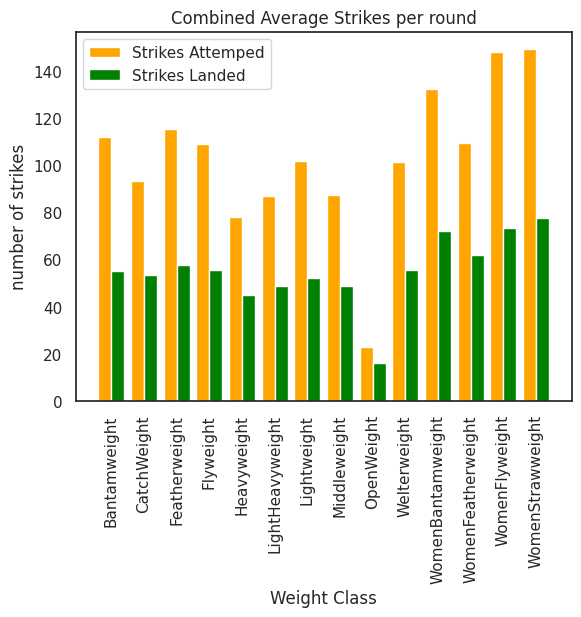

In [ ]:
#strike_app & strike_landed

weight_classes = ['Bantamweight' ,'CatchWeight', 'Featherweight', 'Flyweight', 'Heavyweight','LightHeavyweight', 'Lightweight' ,'Middleweight', 'OpenWeight','Welterweight', 'WomenBantamweight','WomenFeatherweight' ,'WomenFlyweight', 'WomenStrawweight']
blue_strikes = ['B_avg_TOTAL_STR_att','B_avg_TOTAL_STR_landed'] #avg red corner strikes in a match
red_strikes = ['R_avg_TOTAL_STR_att','R_avg_TOTAL_STR_landed'] #avg blue corner strikes in a match
stats = []

for w_class in weight_classes:
    current_data = data.loc[data[w_class] == 1]
    current_data = current_data[[blue_strikes[0],blue_strikes[1],red_strikes[0],red_strikes[1]]]
    Total_avg = current_data.mean(axis=0)
    stats.append({'avg_TOTAL_STR_att': (Total_avg[blue_strikes[0]]+Total_avg[red_strikes[0]])/2, 'avg_TOTAL_STR_landed': (Total_avg[blue_strikes[1]]+Total_avg[red_strikes[1]])/2})


strikes_landed = []
strikes_attempted = []
for i in stats:
    strikes_landed.append(i['avg_TOTAL_STR_landed'])
    strikes_attempted.append(i['avg_TOTAL_STR_att'])
X_axis = np.arange(len(weight_classes))
plt.xticks(X_axis,weight_classes, rotation=90)
plt.xlabel("Weight Class")
plt.ylabel("number of strikes")

plt.bar(X_axis - 0.2, strikes_attempted, 0.4, label = 'Strikes Attemped',color='orange')
plt.bar(X_axis + 0.2, strikes_landed, 0.4, label = 'Strikes Landed',color='green')
plt.title("Combined Average Strikes per round")
plt.legend()
plt.show()

#### Grappling statistics by weightclass 

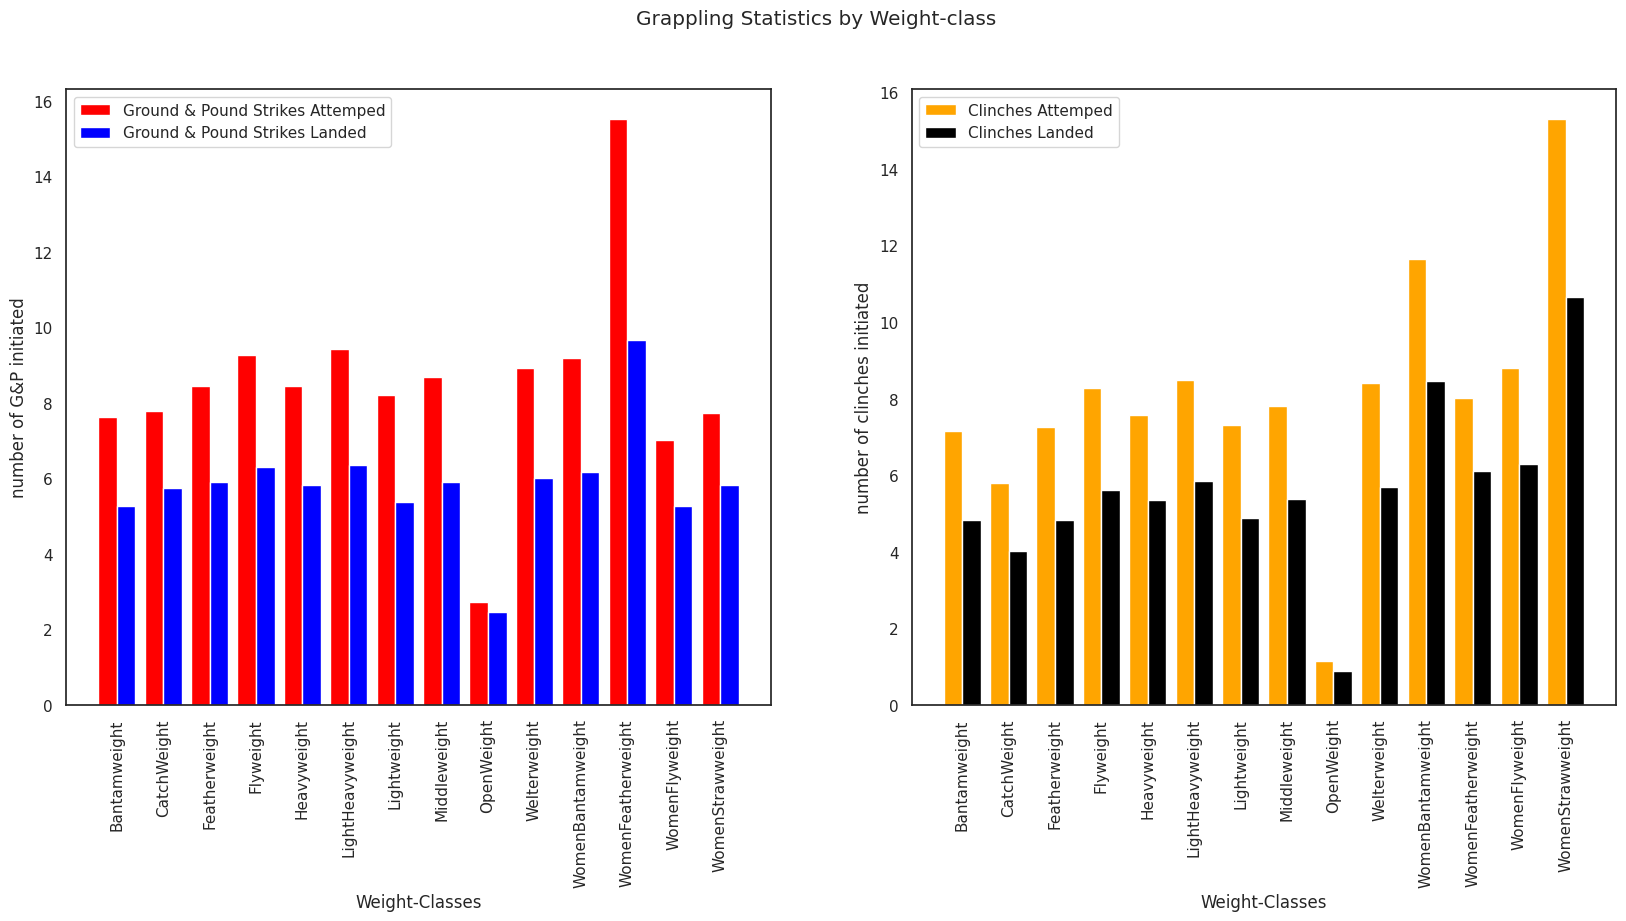

In [ ]:
blue_clinch = ['B_avg_CLINCH_att', 'B_avg_CLINCH_landed']
red_clinch = ['R_avg_CLINCH_att', 'R_avg_CLINCH_landed']
blue_ground = ['B_avg_GROUND_att', 'B_avg_GROUND_landed']
red_ground = ['R_avg_GROUND_att', 'R_avg_GROUND_landed']


ground = []
clinch = []

for w_class in weight_classes:
    current_data = data.loc[data[w_class] == 1]
    current_data = current_data[[blue_clinch[0],blue_clinch[1],red_clinch[0],red_clinch[1],blue_ground[0],blue_ground[1],red_ground[0],red_ground[1]]]
    Total_avg = current_data.mean(axis=0)
    ground.append({'avg_TOTAL_GRD_att': (Total_avg[blue_ground[0]]+Total_avg[red_ground[0]])/2, 'avg_TOTAL_GRD_landed': (Total_avg[blue_ground[1]]+Total_avg[red_ground[1]])/2})
    clinch.append({'avg_TOTAL_CLN_att': (Total_avg[blue_clinch[0]]+Total_avg[red_clinch[0]])/2, 'avg_TOTAL_CLN_landed': (Total_avg[blue_clinch[1]]+Total_avg[red_clinch[1]])/2})


ground_landed = []
ground_attempted = []
clinch_landed = []
clinch_attempted = []

for i in range(len(ground)):
    ground_landed.append(ground[i]['avg_TOTAL_GRD_landed'])
    ground_attempted.append(ground[i]['avg_TOTAL_GRD_att'])
    clinch_landed.append(clinch[i]['avg_TOTAL_CLN_landed'])
    clinch_attempted.append(clinch[i]['avg_TOTAL_CLN_att'])

fig, ax = plt.subplots(1, 2, figsize=(20,8))
ax[0].set_xticks(X_axis,weight_classes, rotation=90)
ax[1].set_xticks(X_axis,weight_classes, rotation=90)

fig.suptitle('Grappling Statistics by Weight-class')
ax[0].set_ylabel("number of G&P initiated")
ax[0].set_xlabel("Weight-Classes")

ax[0].bar(X_axis - 0.2, ground_attempted, 0.4, label = 'Ground & Pound Strikes Attemped',color='red')
ax[0].bar(X_axis + 0.2, ground_landed, 0.4, label = 'Ground & Pound Strikes Landed',color='blue')

ax[1].set_ylabel("number of clinches initiated")
ax[1].set_xlabel("Weight-Classes")

ax[1].bar(X_axis - 0.2, clinch_attempted, 0.4, label = 'Clinches Attemped',color='orange')
ax[1].bar(X_axis + 0.2, clinch_landed, 0.4, label = 'Clinches Landed',color='black')

ax[0].legend()
ax[1].legend()
plt.show()

Looking at the previous data - some trends become obvious.
- The Openweight Category can be treated as an outlier; looking at the history UFC - this was a short-lived category that was featured in the first 6 UFC tournaments and allowed fighters of any weights to go against each other. These fights were done for the sole purpose of curiosity and entertainment.
- Striking: We can see a general trend with more average strikes occuring in the lighter weight classes and lessening going up. This could be due to the fact that generally lighter people have a lot energy and fatigue less easily than heavier people. The lighter one is, the weaker their punches tend to be as well and so can unload a lot more punches in a fight. With a stronger punch, comes a lot more knockout-power and increase the chance of cutting a fight short by knocking-out an opponent, so will have less average punches overrall.
- Grappling: In the grappling statistics we see a similar trend amongst all the weight-classes with similar attempts and succesful actions. We would assume this would be due to the fact that initiating grappling is quite different to striking. Often times, in a fight in a specific round a fighter will initiate a grappling technique, land it succesfully, and then control them in the position till the end of the round. There are fighters out there who do not grapple at all (such as current Middleweight champion Israel Adesanya), so the data associated with grappling will have a lot more 0 values.
- Women's statistics: The women's division was introduced into the UFC in 2013 and still to this day does not have as large a roster or frequent fights as the Mens division, so the data is skewed. However despite being skewed, we still see the same trend amongst the women's divisions in terms of lighter divisions have more average strikes thrown per fight.

#### Do Winners generally have more significant strikes?

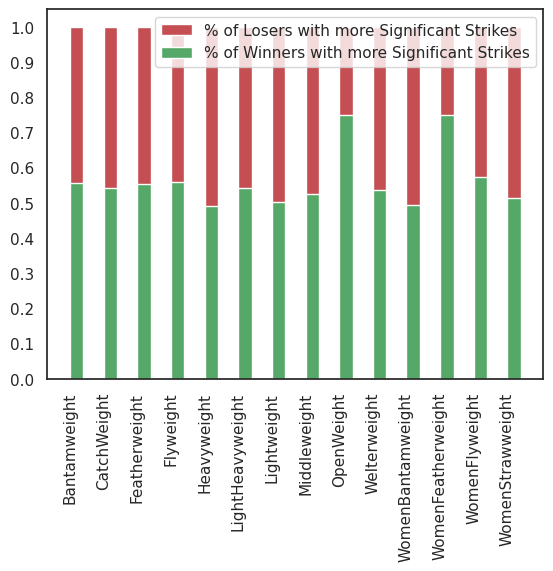

In [ ]:
win = []
for w_class in weight_classes:
    current = data.loc[data[w_class] == 1]
    winners = current.loc[((current['Winner Blue'] == 1) & (current['B_avg_SIG_STR_landed'] > current['R_avg_SIG_STR_landed'])) | ((current['Winner Red'] == 1) & (current['R_avg_SIG_STR_landed'] > current['B_avg_SIG_STR_landed']))]
    percentage = winners.shape[0]/current.shape[0]
    win.append(percentage)

loss = [1 for i in win]

plt.yticks(np.arange(0, 1.0001, step=0.1))
plt.xticks(X_axis,weight_classes, rotation=90)
plt.bar(weight_classes, loss, align='edge', width=0.4, color='r', label='% of Losers with more Significant Strikes')
plt.bar(weight_classes, win, align='edge', width=0.4, color='g',label='% of Winners with more Significant Strikes')
plt.legend()
plt.show()


In [ ]:
data.head()

,Bantamweight,CatchWeight,Featherweight,Flyweight,Heavyweight,LightHeavyweight,Lightweight,Middleweight,OpenWeight,Welterweight,...,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,170.18,177.80,135.0,31.0,27.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1,0,3,0,0,182.88,187.96,185.0,32.0,28.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,2,2,0,167.64,172.72,135.0,29.0,43.0
5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1,2,2,2,0,182.88,190.50,155.0,27.0,41.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,1,3,0,0,182.88,180.34,170.0,35.0,31.0


#### Each Stances preferred strike

In [ ]:
def df_column_uniquify(df):
    df_columns = df.columns
    new_columns = []
    for item in df_columns:
        counter = 0
        newitem = item
        while newitem in new_columns:
            counter += 1
            newitem = "{}_{}".format(item, counter)
        new_columns.append(newitem)
    df.columns = new_columns
    return df

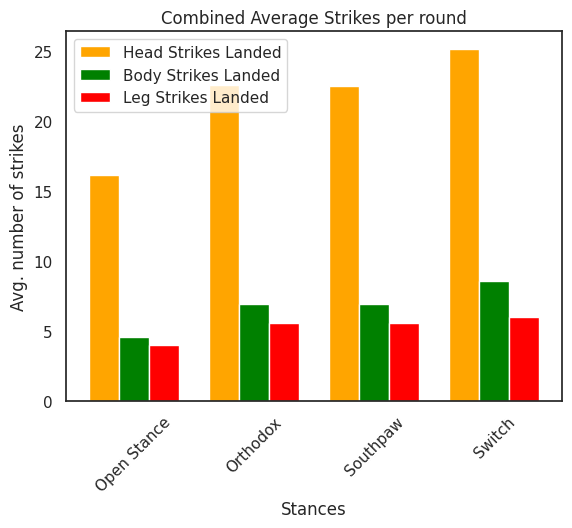

In [ ]:
stances = [('Open Stance','Open Stance_1'),('Orthodox','Orthodox_1'),('Southpaw','Southpaw_1'),('Switch','Switch_1')]



strikes_b = ['B_avg_HEAD_landed','B_avg_BODY_landed', 'B_avg_LEG_landed']
strikes_r = ['R_avg_HEAD_landed','R_avg_BODY_landed', 'R_avg_LEG_landed']

temp_data = data #so to not mess up anything
temp_data = df_column_uniquify(temp_data)
only_stance = [stance[0] for stance in stances]

striking = {}
for stance in stances:
    #_1 corresponds to red, non to blue
    current_b = temp_data.loc[(temp_data[stance[0]] == 1)]
    current_b = current_b[strikes_b].mean()
    
    current_r = temp_data.loc[(temp_data[stance[1]] == 1)]
    current_r = current_r[strikes_r].mean()

    Total = []
    for i in range(len(current_b)):
        Total.append((current_b[i] + current_r[i])/2)
    
    striking[stance[0]] = Total

head_strikes = [strike[0] for strike in striking.values()]
body_strikes = [strike[1] for strike in striking.values()]
leg_strikes = [strike[2] for strike in striking.values()]


N = 4
ind = np.arange(N) 
width = 0.25

plt.xticks(ind+width, list(striking.keys()), rotation=45)
plt.xlabel("Stances")
plt.ylabel("Avg. number of strikes")

plt.bar(ind, head_strikes, width, label = 'Head Strikes Landed',color='orange')
plt.bar(ind+width, body_strikes, width, label = 'Body Strikes Landed',color='green')
plt.bar(ind+width*2, leg_strikes, width, label = 'Leg Strikes Landed',color='red')

plt.title("Combined Average Strikes per round")
plt.legend()
plt.show()


#### Wins and Losses per weight-class

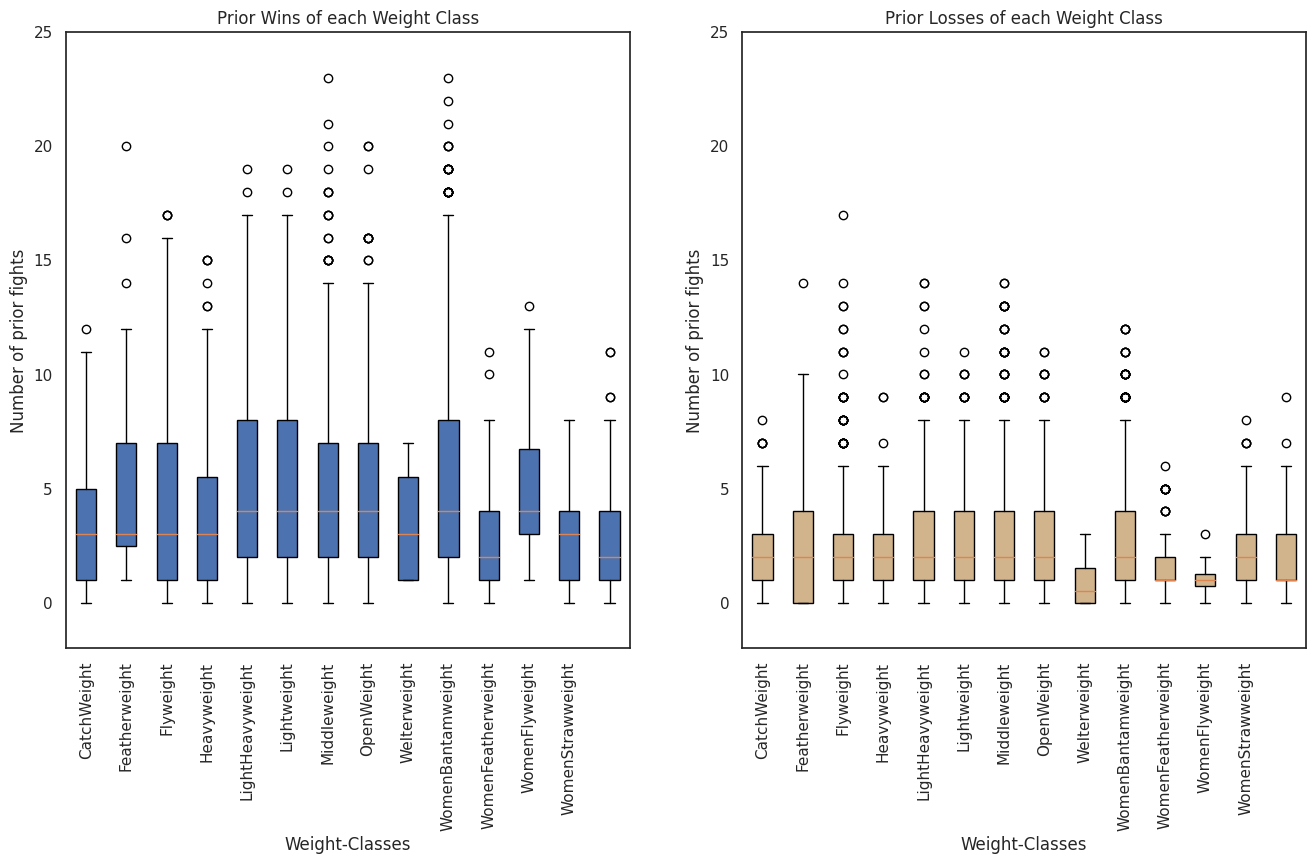

In [ ]:
red_record = ['R_wins', 'R_losses']
blue_record = ['B_wins', 'B_losses']
red_record.extend(blue_record)

wins_losses = []

for weight in weight_classes:
    current = data.loc[data[weight] == 1]
    current = current[red_record]
    wins = current['R_wins'].to_numpy()
    np.concatenate((wins, current['B_wins'].to_numpy()),axis=None)

    losses = current['R_losses'].to_numpy()
    np.concatenate((losses, current['B_losses'].to_numpy()),axis=None)
    
    wins_losses.append((wins,losses))

wins = [data[0] for data in wins_losses]
loss = [data[1] for data in wins_losses]


fig, ax = plt.subplots(1, 2, figsize=(16,8))
ax[0].set_xticks(X_axis,weight_classes, rotation=90)

# Creating axes instance
# Creating plot
ax[0].boxplot(wins, labels=weight_classes, patch_artist=True)
ax[0].set_ylim(-2,25)
ax[0].set_ylabel("Number of prior fights")
ax[0].set_xlabel("Weight-Classes")
ax[0].set_title("Prior Wins of each Weight Class")
# show plot

ax[1].set_xticks(X_axis,weight_classes, rotation=90)

# Creating axes instance
# Creating plot
box_loss = ax[1].boxplot(loss, labels=weight_classes, patch_artist=True)

ax[1].set_xlabel("Weight-Classes")
ax[1].set_ylabel("Number of prior fights")
ax[1].set_title("Prior Losses of each Weight Class")
ax[1].set_ylim(-2,25)


colors = []
for i in range(len(weight_classes)):
    colors.append('tan')
for patch, color in zip(box_loss['boxes'], colors):
    patch.set_facecolor(color)
# show plot
plt.show()

## (1.6) Visualizations to understand the remaining features 

### Looking at the frequency each corner wins with

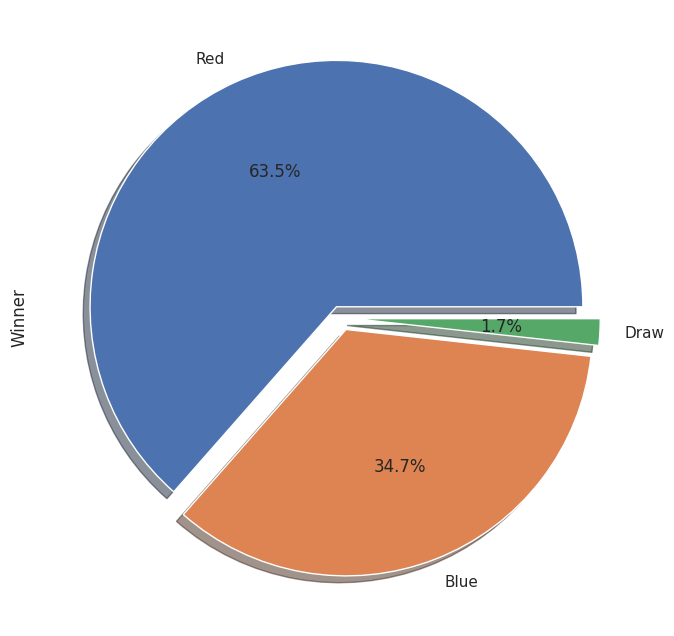

In [ ]:
plt.figure(figsize=(15,8))
targetsForImportances.value_counts()[:10].plot.pie(explode=[0.05,0.05,0.05],autopct='%1.1f%%',shadow=True)
plt.show()

- We can see that majority of the wins occur in the red corner and so a model should be able to predict this class better than the others. 
- Draws are very few and thus might be the results we predict incorrectly since there are too few data instances to learn from.

In [ ]:
data.columns

Index(['Bantamweight', 'CatchWeight', 'Featherweight', 'Flyweight',
       'Heavyweight', 'LightHeavyweight', 'Lightweight', 'Middleweight',
       'OpenWeight', 'Welterweight',
       ...
       'R_win_by_Decision_Split', 'R_win_by_Decision_Unanimous',
       'R_win_by_KO/TKO', 'R_win_by_Submission',
       'R_win_by_TKO_Doctor_Stoppage', 'R_Height_cms', 'R_Reach_cms',
       'R_Weight_lbs', 'B_age', 'R_age'],
      dtype='object', length=161)

### Looking at the distribution of the fighters height, reach and age

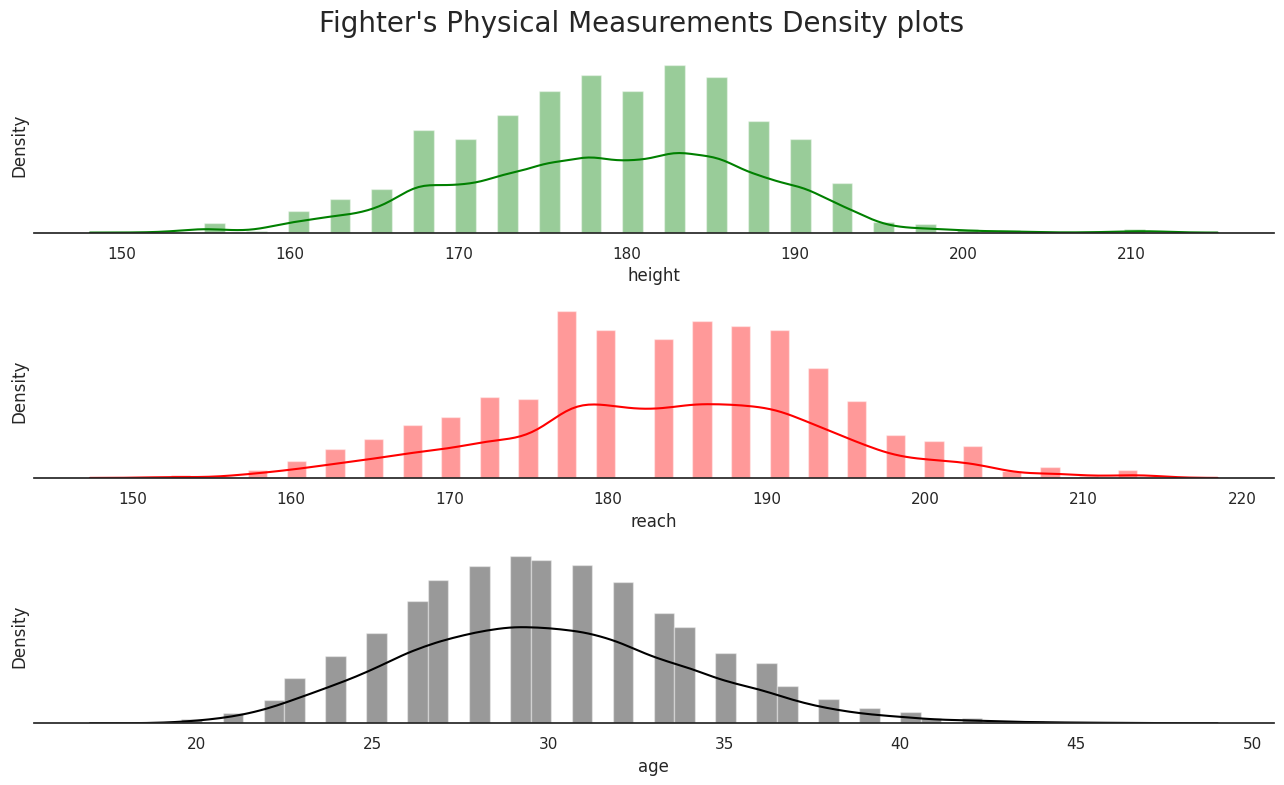

In [ ]:
# combine measures of both blue and red fighter
height = pd.concat([data["B_Height_cms"],data["R_Height_cms"]],axis=0)
reach = pd.concat([data["B_Reach_cms"],data["R_Reach_cms"]],axis=0)
age = pd.concat([data["B_age"],data["R_age"]],axis=0)
fighter_measures = pd.DataFrame({"height":height, "reach":reach, "age":age}).reset_index(drop=True).dropna()

# subplots:
fig4, axes = plt.subplots(3, 1, figsize=(13, 8), sharex=False) # Grid
fig4.suptitle("Fighter's Physical Measurements Density plots",fontsize=20) # Main title
sns.despine(left=True,right=True) # remove axis border

sns.distplot(fighter_measures["height"],color="green",
              ax=axes[0] # position in grid
            )
sns.distplot(fighter_measures["reach"],color="red",ax=axes[1])
sns.distplot(fighter_measures["age"],color="black",ax=axes[2])

plt.setp(axes, yticks=[]) # y-ticks range disabled
plt.tight_layout() #auto-adjusts subplots to the figure area

### Exploring age against winning and losing

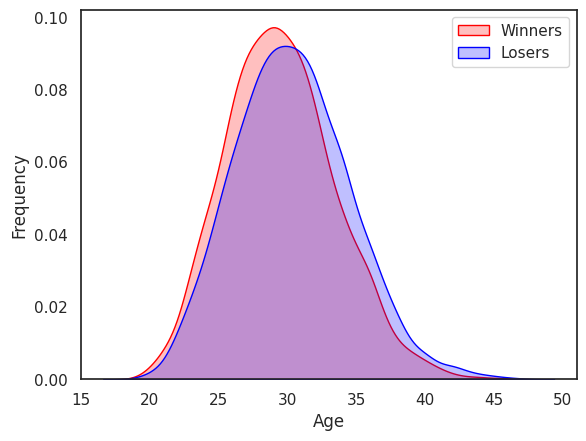

In [ ]:
# Explore Age distibution 
winners_age_combinded = pd.concat([data["B_age"][(data["Winner"] == "Blue") ], # age of blue winners
                                   data["R_age"][(data["Winner"] == "Red") ] # age of red winners
                                  ]).reset_index(drop=True)

losers_age_combinded = pd.concat([data["B_age"][(data["Winner"] == "Red") ], # when winner was 0(red), what's the age of loser (b_age)
                                   data["R_age"][(data["Winner"] == "Blue") ] # same logic as above. age of red loser
                                  ]).reset_index(drop=True)
g = sns.kdeplot(winners_age_combinded, color="Red", shade = True)
g = sns.kdeplot(losers_age_combinded, color="Blue", shade = True, ax=g)


g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Winners","Losers"])

In [ ]:
features.columns

Index(['title_bout', 'B_avg_KD', 'B_avg_opp_KD', 'B_avg_SIG_STR_pct',
       'B_avg_opp_SIG_STR_pct', 'B_avg_TD_pct', 'B_avg_opp_TD_pct',
       'B_avg_SUB_ATT', 'B_avg_opp_SUB_ATT', 'B_avg_REV', 'B_avg_opp_REV',
       'B_avg_TD_att', 'B_avg_TD_landed', 'B_avg_opp_TD_att',
       'B_avg_opp_TD_landed', 'B_avg_CTRL_time(seconds)',
       'B_avg_opp_CTRL_time(seconds)', 'B_total_time_fought(seconds)',
       'B_total_title_bouts', 'B_current_win_streak', 'B_current_lose_streak',
       'B_longest_win_streak', 'B_draw', 'B_win_by_Decision_Majority',
       'B_Height_cms', 'B_Reach_cms', 'R_avg_KD', 'R_avg_opp_KD',
       'R_avg_SIG_STR_pct', 'R_avg_opp_SIG_STR_pct', 'R_avg_TD_pct',
       'R_avg_opp_TD_pct', 'R_avg_SUB_ATT', 'R_avg_opp_SUB_ATT', 'R_avg_REV',
       'R_avg_opp_REV', 'R_avg_TD_att', 'R_avg_TD_landed', 'R_avg_opp_TD_att',
       'R_avg_opp_TD_landed', 'R_avg_CTRL_time(seconds)',
       'R_avg_opp_CTRL_time(seconds)', 'R_total_time_fought(seconds)',
       'R_total_title_bou

## (1.7) Scaling the data

In [ ]:
sc = StandardScaler()
cols = features.columns
features = pd.DataFrame(sc.fit_transform(features),columns=cols)

# (2) Finding the importances of the features so we can only choose the most important ones for our model

## (2.1) Using embedded methods to find optimal features

 - Embedded methods are iterative in a sense that takes care of each iteration of the model training process and carefully extract those features which contribute the most to the training for a particular iteration. Regularization methods are the most commonly used embedded methods which penalize a feature given a coefficient threshold.
 - Embedded methods are iterative in a sense that takes care of each iteration of the model training process and carefully extract those features which contribute the most to the training for a particular iteration. Regularization methods are the most commonly used embedded methods which penalize a feature given a coefficient threshold.

### (2.1.1) Using Logistic Regression with L1 regularisation

- Regularisation consists in adding a penalty to the different parameters of the machine learning model to reduce the freedom of the model and in other words to avoid overfitting. In linear model regularisation, the penalty is applied over the coefficients that multiply each of the predictors. From the different types of regularisation, Lasso or l1 has the property that is able to shrink some of the coefficients to zero. Therefore, that feature can be removed from the model.

In [ ]:
logistic = LogisticRegression(C=0.03, penalty="l1", solver='liblinear', random_state=7)
model_Logistic = SelectFromModel(logistic)  # this chooses the best features for us!
model_Logistic.fit(features, targetsForImportances)

selected_feat_lr = features.columns[(model_Logistic.get_support())]
print('total features: {}'.format((features.shape[1])))
print('selected features: {}'.format(len(selected_feat_lr)))

total features: 53
selected features: 35


### (2.1.2) Using a Linear SVC with L1 regularization

In [ ]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(features, targetsForImportances)
model_svc = SelectFromModel(lsvc)
model_svc.fit(features,targetsForImportances)
selected_feat_svc = features.columns[(model_svc.get_support())]
print('total features: {}'.format((features.shape[1])))
print('selected features: {}'.format(len(selected_feat_svc)))

total features: 53
selected features: 38


### (2.1.3) Using a Random Forest 

- Random forests are one the most popular machine learning algorithms. They are so successful because they provide in general a good predictive performance, low overfitting and easy interpretability. This interpretability is given by the fact that it is straightforward to derive the importance of each variable on the tree decision. In other words, it is easy to compute how much each variable is contributing to the decision.
- Random forests consist of 4-12 hundred decision trees, each of them built over a random extraction of the observations from the dataset and a random extraction of the features. Not every tree sees all the features or all the observations, and this guarantees that the trees are de-correlated and therefore less prone to over-fitting. Each tree is also a sequence of yes-no questions based on a single or combination of features. At each node (this is at each question), the three divides the dataset into 2 buckets, each of them hosting observations that are more similar among themselves and different from the ones in the other bucket. Therefore, the importance of each feature is derived by how "pure" each of the buckets is.
- For classification, the measure of impurity is either the Gini impurity or the information gain/entropy. For regression the measure of impurity is variance. Therefore, when training a tree, it is possible to compute how much each feature decreases the impurity. The more a feature decreases the impurity, the more important the feature is. In random forests, the impurity decrease from each feature can be averaged across trees to determine the final importance of the variable.
- To give a better intuition, features that are selected at the top of the trees are in general more important than features that are selected at the end nodes of the trees, as generally the top splits lead to bigger information gains.

In [ ]:
model = RandomForestClassifier(n_estimators=250, random_state=42, max_depth=10)
# fit the model to start training.
model.fit(features,targetsForImportances)
# get the importance of the resulting features.
importances = model.feature_importances_
# create a data frame for visualization.
final_df = pd.DataFrame({ "Features": pd.DataFrame(features).columns, "Importances": importances})
final_df.set_index('Importances')
# sort in ascending order to better visualization.
final_df = final_df.sort_values('Importances',ascending= False)
random_forest = final_df[:53].to_numpy()
random_forest = list(random_forest[:,0])

## (2.2) Using filter methods to find optimal features

- Filter methods are generally used as a preprocessing step. The selection of features is independent of any machine learning algorithms. Instead, features are selected on the basis of their scores in various statistical tests for their correlation with the outcome variable. The characteristics of these methods are as follows:

     1. These methods rely on the characteristics of the data (feature characteristics)
     2. They do not use machine learning algorithms.
     3. These are model agnostic.
     4. They tend to be less computationally expensive.
     5. They usually give lower prediction performance than wrapper methods.
     6. They are very well suited for a quick screen and removal of irrelevant features.


### (2.2.1) Using Information Gain

-  Information gain or mutual information measures how much information the presence/absence of a feature contributes to making the correct prediction on the target.
- It estimates mutual information for a discrete target variable.
- Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

In [ ]:
information_gain = mutual_info_classif(features,targetsForImportances,random_state=7)

info_gain_importances  = pd.DataFrame(information_gain,features.columns,columns =["Importances"])
info_gain_importances = info_gain_importances.sort_values("Importances",ascending=False)

important_feats_indices = np.where(info_gain_importances.to_numpy() != 0)
labels = np.array(features.columns)
ig_feats = []
for i in important_feats_indices[0]:
    ig_feats.append(labels[i])

print('total features: {}'.format((features.shape[1])))
print('selected features: {}'.format(len(ig_feats)))

total features: 53
selected features: 29


### (2.2.2) Using Chi-Square 

- The Chi-square test is used for categorical features in a dataset.
- We calculate Chi-square between each feature and the target and select the desired number of features with the best Chi-square scores.

In [ ]:
targs.extend(ColumnsWithHighCollinearity)
unscaled_features = data.drop(columns= targs,axis=1)
chi = SelectKBest(chi2,k=50)
p_vals = chi.fit_transform(unscaled_features,LabelEncoder().fit_transform(targetsForImportances))
selected_feat_chi2 = features.columns[(chi.get_support())]
print('total features: {}'.format((features.shape[1])))
print('selected features: {}'.format(len(selected_feat_chi2)))


total features: 53
selected features: 50


## (2.3) Wrapper Methods

- In wrapper methods, we try to use a subset of features and train a model using them. Based on the inferences that we draw from the previous model, we decide to add or remove features from the subset. The problem is essentially reduced to a search problem. These methods are usually computationally very expensive.
- The algorithm starts from all features and greedily eliminates the least important feature. Once all features are removed, the algorithm returns the subset which gives the best performance.

### (2.3.1) Using Recursive feature elimination with cross-validation

- Recursive Feature Elimination with Cross-Validated (RFECV) feature selection technique selects the best subset of features for the estimator by removing 0 to N features iteratively using recursive feature elimination.
- Then it selects the best subset based on the accuracy or cross-validation score or roc-auc of the model. Recursive feature elimination technique eliminates n features from a model by fitting the model multiple times and at each step, removing the weakest features.

In [ ]:
model_for_RFEWCV = RandomForestClassifier(n_estimators=250, random_state=42, max_depth=10)
rfe = RFECV(model_for_RFEWCV,
            step=1,
            cv=2,
            scoring= 'accuracy',
           verbose= 1)
rfe = rfe.fit(features, targetsForImportances)
selected_feat_rfe = features.columns[(rfe.get_support())]
print('total features: {}'.format((features.shape[1])))
print('selected features: {}'.format(len(selected_feat_rfe)))


Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 fe

## (2.4) Selecting the best features based on the common features returned by all the above processes

In [ ]:
Features = list(set(random_forest).intersection(selected_feat_svc)
                .intersection(selected_feat_lr)
                .intersection(ig_feats)
                .intersection(selected_feat_chi2)
                .intersection(selected_feat_rfe))
print(f"The initial number of features is: {features.shape[1]}")
print(f"The number of features selected is: {len(Features)}")
print(f"The number of features removed is: {features.shape[1] - len(Features)}")

The initial number of features is: 53
The number of features selected is: 16
The number of features removed is: 37


In [ ]:
SelectedFeatures = features[Features]

In [ ]:
print(SelectedFeatures)

      B_avg_opp_TD_att  B_avg_opp_CTRL_time(seconds)  B_longest_win_streak  \
0             2.220963                      1.130234             -0.670698   
1            -0.876123                     -0.852624             -0.116660   
2            -0.329578                      0.180441              0.437378   
3            -0.967213                     -0.908465              0.991416   
4            -0.492545                     -0.416884             -0.670698   
...                ...                           ...                   ...   
4255         -0.534532                     -1.044640              0.991416   
4256         -1.058304                     -1.044640              0.437378   
4257         -0.850503                     -1.044640              3.207567   
4258         -1.058304                     -1.044640             -0.116660   
4259         -0.876123                     -1.044640              0.437378   

      R_avg_SIG_STR_pct  B_avg_SIG_STR_pct  R_avg_opp_KD  B_avg

## (2.5) Splitting into training,validation and testing sets

In [ ]:
Train_Features, Temp_Features, Train_Targets, Temp_Targets = train_test_split(SelectedFeatures, targets, test_size=0.3, random_state=42)
Validation_Features, Test_Features, Validation_Targets, Test_Targets = train_test_split(Temp_Features, Temp_Targets, test_size=0.3, random_state=42)

# Helper Functions

A function that will take in one-hot encoded targets or the predictions of a network and convert it into a list of single predictions. These predictions either being Red or Blue as winner or a draw.

In [ ]:
def Convert_Targets(Targets):
    test = list()
    for i in range(len(np.asarray(Targets))):
            test.append(np.argmax(np.asarray(Targets)[i]))
    
    return test

A function that will plot the loss during training as well as validation if we implement early stopping

In [ ]:
def plot_metric(history, metric,earlyStopping):
    if(earlyStopping):
        train_metrics = history.history[metric]
        val_metrics = history.history['val_'+metric]
        epochs = range(1, len(train_metrics) + 1)
        plt.plot(epochs, train_metrics)
        plt.plot(epochs, val_metrics)
        plt.title('Training and validation '+ metric)
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend(["train_"+metric, 'val_'+metric])
        plt.show()
    else:
        train_metrics = history.history[metric]
        epochs = range(1, len(train_metrics) + 1)
        plt.plot(epochs, train_metrics)
        plt.title('Training '+ metric)
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.show()

A method that will take in the one-hot encoded actual targets and the probabilities predicted by the Neural Network, convert them into single targets and then calculate the accuracy score and provide a confusion matrix.

In [ ]:
def getAccuracy(predicted,actual,alreadyFiltered):
    if(not alreadyFiltered):
        true_targets = Convert_Targets(actual)
        model_predictions = Convert_Targets(predicted)
        acc = accuracy_score(true_targets,model_predictions)
        print(f"The accuracy is: {np.round(acc*100,4)}")
        mat = confusion_matrix(true_targets,model_predictions)
        sns.heatmap(mat,fmt='g',annot=True)
        plt.xlabel("Predicted ")
        plt.ylabel("True Values")
        plt.show()
        return acc
    else:
        acc = accuracy_score(actual,predicted)
        print(f"The accuracy is: {np.round(acc*100,4)}")
        mat = confusion_matrix(actual,predicted)
        sns.heatmap(mat,fmt='g',annot=True)
        plt.xlabel("Predicted ")
        plt.ylabel("True Values")
        plt.show()
        return acc

# (3) Machine Learning Models

## (3.1) Extreme Gradient Boosting (XGBoost)

### Explaining XGBoost 
XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework.<br>
When it comes to small-to-medium structured/tabular data, decision tree based algorithms are considered best-in-class right now. <br>
### 1. Decision Trees:
- Decision trees are supervised machine learning algorithm that is used for both classification and regression tasks.
- Decision Trees are a tree-like model that can be used to predict the class/value of a target variable and Decision trees handle non-linear data effectively.
- In the decision trees, at each node, the split is done based on the feature. If the feature is a continuous variable, the splitting condition is made on a certain threshold. If the feature is a categorical variable, the splitting condition is made on all the values. Since we are doing classification, we will focus on that.
- The criteria used to calculate the best split are:
    1. Classification Error: Split is done based on each feature. For each feature, the change in classification error is calculated and the feature which gives the maximum classification error change is chosen for the split. However since it is possible to end up with a 0 change in error, the method is not preferred.
    2. Entropy: Entropy is used to measure the homogeneity of a node in the decision tree. If the node is homogenous, entropy is 0. Entropy refers to impurity. Reduction in entropy (impurity) is known as Information Gain. If the information gain is more for a particular split, that split condition is executed first.Reduction in entropy (impurity) is known as Information Gain. If the information gain is more for a particular split, that split condition is executed first.
    3. Gini-index: Gini-index is another measure of impurity.
- Decision trees tend to overfit and are a high variance model. Thus it is incapable of generalizing well.
- Besides utilising pruning, bagging is used to reduce the variance of the model.
## Ensemble Modelling <br>
- Ensemble learning offers a systematic solution to combine the predictive power of multiple learners. The resultant is a single model that gives the aggregated output from several models.
- The models that form the ensemble, also known as base learners, could be either from the same learning algorithm or different learning algorithms.
- bagging and boosting are two highly praised ensemble learners

### 2. Bagging :<br>

- Bagging means building different models using sample subset and then aggregating the predictions of the different models to reduce variance.
- Bagging means Bootstrap Aggregation.
- Bootstrapping helps to create multiple subsets from the training data. Then we can build multiple trees on the bootstrapped samples. Bootstrapping will randomly select repeated data points from the training set and create multiple subsets — sampling with replacement.
- Now we have different bootstrap samples and have built ‘B’ decision trees for each ‘B’ bootstrap sample. The next step is aggregating the output.
- Now we have different bootstrap samples and have built ‘B’ decision trees for each ‘B’ bootstrap sample. The next step is aggregating the output.
- Another approach is to get the probability of the class from the ‘B’ trees, and the final class is classified from the average of the probability.

### 3. Boosting :
- Boosting algorithms seek to improve the prediction power by training a sequence of weak models, each compensating the weaknesses of its predecessors.
- As a reminder, a weak learner classifies data slightly better than random guessing.
- Differt boosting algorithms:
    1. Adaptive boosting: This method operates iteratively, identifying misclassified data points and adjusting their weights to minimize the training error. The model continues optimize in a sequential fashion until it yields the strongest predictor. 
    2. Gradient boosting: works by sequentially adding predictors to an ensemble with each one correcting for the errors of its predecessor. However, instead of changing weights of data points like AdaBoost, the gradient boosting trains on the residual errors of the previous predictor. 
    
#### The general boosting procdure is as follows:

- The first weak learner is created and used to classify the data. The results are shown in the image below.
![D1.webp](D1.webp)
We can clearly see that the boundary is incorrect. There are 3 positives that are incorrectly classified. Thus the weights of these misclassified points are increased and the next weak learner will focus on classifying these correctly.
![D2.webp](D2.webp)
- The next weak learner is created and used to classify the data, but the previously misclassified points are focussed on.
We can now see that those previously misclassified points are classified correctly, but there are 3 negative values that are classified incorrecly. Consequently, their weights are increased and will be the focus of the next classifier.
![D3.webp](D3.png)
- The next weak learner is created and used to classify the data, but the previously misclassified points are focussed on.
We can now see that those previously misclassified negative points are classified correctly, but there are 2 negative values that are classified incorrecly. However, those points are classified correctly by the first learner.<br>

If we combine the above weak learners, we end up with a strong learner denoted below:
![D4.webp](D4.webp)


### (3.1.1) Basic XGBoost Model

The training results: 
The accuracy is: 100.0


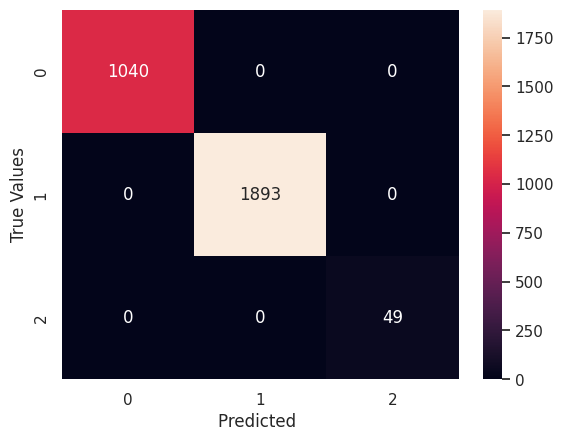

The validation results: 
The accuracy is: 58.5011


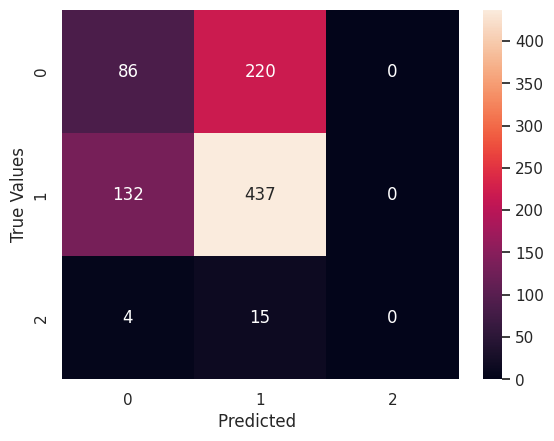

The testing results: 
The accuracy is: 61.4583


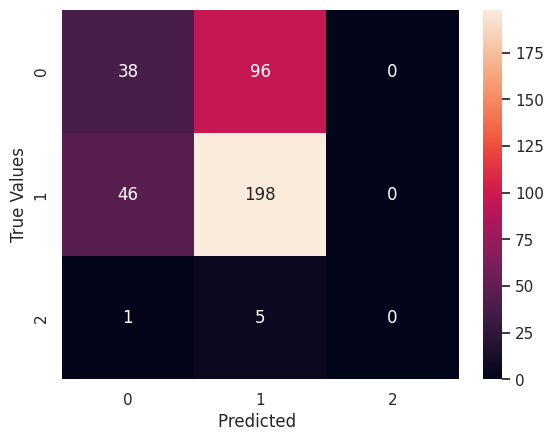

In [ ]:
xgb_basic = xgboost.XGBClassifier(n_estimators=100,
                                 eval_metric = "mlogloss")

xgb_basic.fit(Train_Features, Convert_Targets(Train_Targets))

prediction_basic = xgb_basic.predict(Test_Features)

simple_xg_table = PrettyTable(["Training Accuracy","Validation Accuracy","Testing Accuracy"])

print("The training results: ")
train_acc = getAccuracy(xgb_basic.predict(Train_Features),Convert_Targets(Train_Targets),True)

print("The validation results: ")
valid_acc = getAccuracy(xgb_basic.predict(Validation_Features),Convert_Targets(Validation_Targets),True)

print("The testing results: ")
test_acc = getAccuracy(prediction_basic,Convert_Targets(Test_Targets),True)
simple_xg_table.add_row([train_acc*100,valid_acc*100,test_acc*100])

### (3.1.2) Analysing the simple models results

### Precision-Recall curve for the validation data

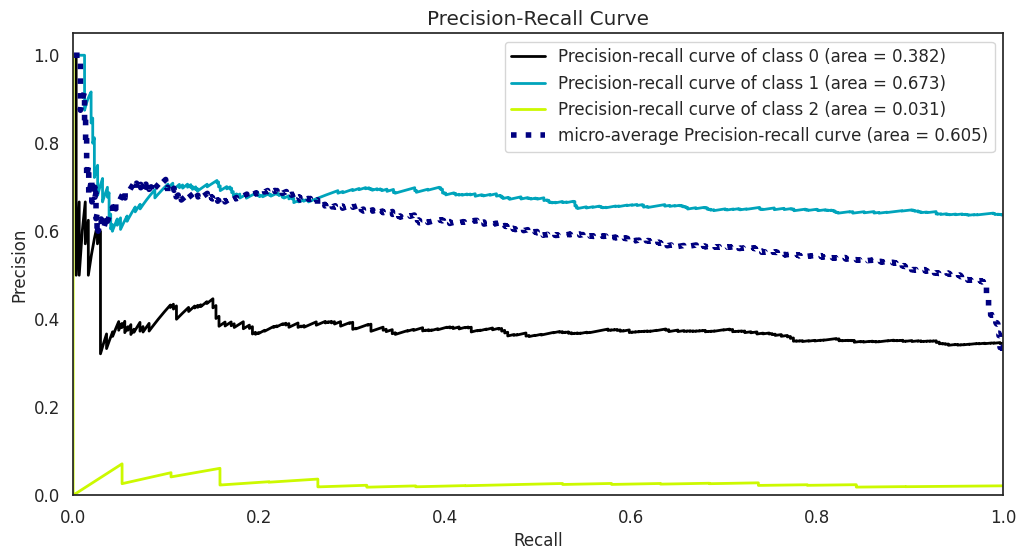

In [ ]:
skplt.metrics.plot_precision_recall_curve(Convert_Targets(Validation_Targets), xgb_basic.predict_proba(Validation_Features),
                       title="Precision-Recall Curve", figsize=(12,6));

### Precision-Recall curve for the testing data

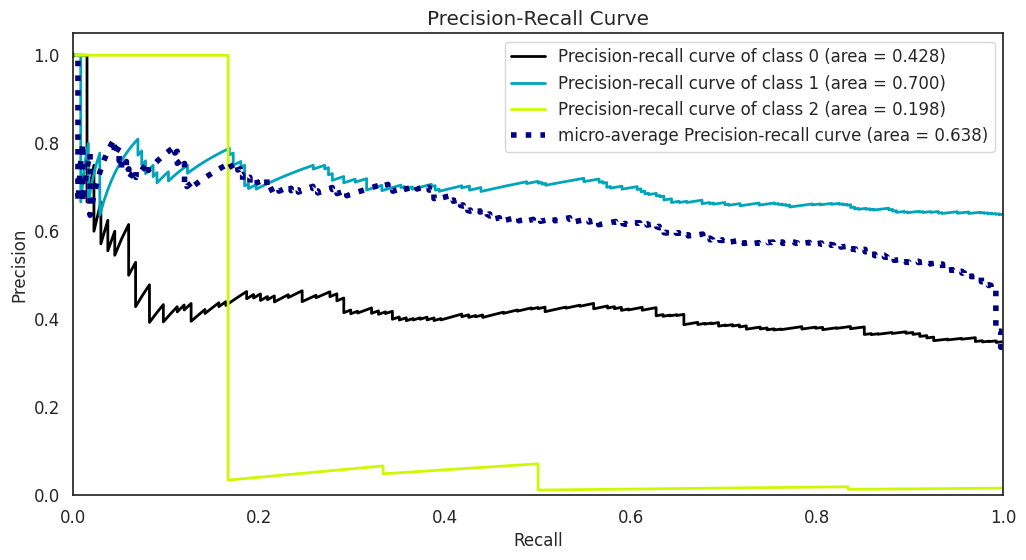

In [ ]:
skplt.metrics.plot_precision_recall_curve(Convert_Targets(Test_Targets), xgb_basic.predict_proba(Test_Features),
                       title="Precision-Recall Curve", figsize=(12,6));

- The area under the each line of the precision-recall curve to be high since this will indicate the model is capable of predicting the correct classes.
- However, we can clearly see that the class 1 achieves the best area under the curve, which indicates the model is good at predicting this class and predicts the other classes poorly.
- This is due to the fact that our targets are imbalanced, and 1 which represents the Red corner, which won majority of the fights.
- The lowest area is represented by class 2 which represents a draw and was the smallest represented outcome.

In [ ]:
print(simple_xg_table)

+-------------------+---------------------+--------------------+
| Training Accuracy | Validation Accuracy |  Testing Accuracy  |
+-------------------+---------------------+--------------------+
|       100.0       |  58.501118568232656 | 61.458333333333336 |
+-------------------+---------------------+--------------------+


- We can see that our validation and testing accuracy is significantly lower than our training accuracy.
- This clearly implies that we have overfit.
- Consequently we have a high variance model.

### (3.2.1) Optimizing the XGBoost parameters

### Parameters:

#### 1. eta/learning rate:
- Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.

#### 2. max_depth:
- Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 0 indicates no limit on depth. Beware that XGBoost aggressively consumes memory when training a deep tree.

#### 3. min_child_weight:
- It defines the minimum sum of weights of all observations required in a child.
- It is used to control over-fitting.
- Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.
- Too high values can lead to under-fitting.

#### 4.  subsample:
- It denotes the fraction of observations to be randomly samples for each tree.
- Subsample ratio of the training instances.
- Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. - This will prevent overfitting.
- Subsampling will occur once in every boosting iteration.
- Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.

#### 5. lambda:
- L2 regularization term on weights (analogous to Ridge regression).
- This is used to handle the regularization part of XGBoost.
- Increasing this value will make model more conservative.

#### 6. alpha:
- L1 regularization term on weights (analogous to Lasso regression).
- It can be used in case of very high dimensionality so that the algorithm runs faster when implemented.
- Increasing this value will make model more conservative.

#### 7. scale_pos_weight :
- It controls the balance of positive and negative weights,
- It is useful for imbalanced classes.
- A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence.
- A typical value to consider: sum(negative instances) / sum(positive instances).

#### 8. N_estimators:
- It determines the number of trees which we use in the ensemble.

In [ ]:
params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'min_child_weight': [1,5,10,20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'n_estimators': [100, 500, 1000],
           'lambda': [1,3,7,15],
           'alpha': [1,3,7,15],
          'scale_pos_weight': [1,3,7,10]
         }
xgbr = xgboost.XGBClassifier(seed = 20,
                             eval_metric = "mlogloss" )

clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='accuracy',
                         n_iter=50,
                         cv = 2,
                         verbose=0)

clf.fit(Train_Features, Convert_Targets(Train_Targets))

[22:51:59] WARNING: ../src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:52:00] WARNING: ../src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:52:01] WARNING: ../src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actual

RandomizedSearchCV(cv=2,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss', gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin...
                                           predictor=None, random_state=None,
                                           reg_alpha=None, r

In [ ]:
xgb_df = pd.DataFrame(clf.cv_results_)
print("Best parameters:", clf.best_params_)
print("Best accuracy: ", (clf.best_score_))

Best parameters: {'subsample': 0.6, 'scale_pos_weight': 1, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.01, 'lambda': 3, 'alpha': 3}
Best accuracy:  0.6368209255533199


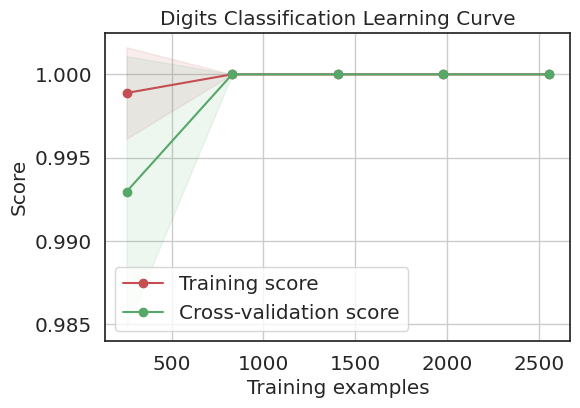

In [ ]:
import scikitplot as skplt
skplt.estimators.plot_learning_curve(LogisticRegression(), Train_Targets, Convert_Targets(Train_Targets),
                                     cv=7, shuffle=True, scoring="accuracy",
                                     n_jobs=-1, figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Digits Classification Learning Curve");

## (3.2) Neural Network

### Building the Neural Network

- We use this function to build a simple netwokr with 1 hidden layer and 10 neurons in the hidden layer.
- The default optimizer is Stochastic Gradient Descent and initializer is uniform.
- The loss function used is categorical loss entropy since we have a multiclass classification problem.

In [ ]:
def Create_Model(initalizer = 'glorot_uniform',
                 optimizer = 'sgd',
                 hidden_layers = 1,
                 activation = "sigmoid",
                 neurons = 10,
                 Train_Features = Train_Features):
    
    NN = Sequential()
    NN.add(Dense(neurons,input_dim=Train_Features.shape[1],activation = activation,kernel_initializer=initalizer))
        
    if(hidden_layers>1):
        for i in range(hidden_layers):
            NN.add(Dense(neurons,activation=activation, initalizer = "glorot_uniform"))
                
    ## We always want the final layer to have 3 neurons with a softmax activation
    NN.add(Dense(3,activation='softmax',kernel_initializer=initalizer))
    
    
    NN.compile(loss='categorical_crossentropy',
           optimizer= optimizer,
           metrics=['accuracy'])
    
    return NN

def Create_Model_2(initalizer = 'glorot_uniform',
                 optimizer = 'sgd',
                 hidden_layers = 1,
                 activation = "sigmoid",
                 neurons = 10,
                 Train_Features = Train_Features):
    
    NN = Sequential()
    if(activation == "sigmoid" or activation == "tanh"):
        NN.add(Dense(neurons,input_dim=Train_Features.shape[1],activation = activation,kernel_initializer=initalizer))
    else:
        NN.add(Dense(neurons,input_dim=Train_Features.shape[1],activation = activation,kernel_initializer="He"))
        
    if(hidden_layers>1):
        for i in range(hidden_layers):
            if(activation == "sigmoid" or activation == "tanh"):
                NN.add(Dense(neurons,activation=activation, initalizer = "glorot_uniform"))
            else:
                NN.add(Dense(neurons,activation=activation, initalizer = "He"))
                
    ## We always want the final layer to have 3 neurons with a softmax activation
    NN.add(Dense(3,activation='softmax',kernel_initializer=initalizer))
    
    
    NN.compile(loss='categorical_crossentropy',
           optimizer= optimizer,
           metrics=['accuracy'])
    
    return NN

### (3.2.1) A simple Neural Network 

- Using the basic setup we already have defined above

The training Error and Accuracy graphs: 


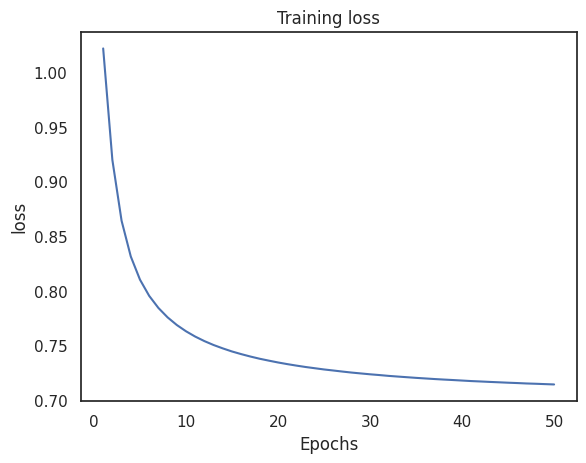

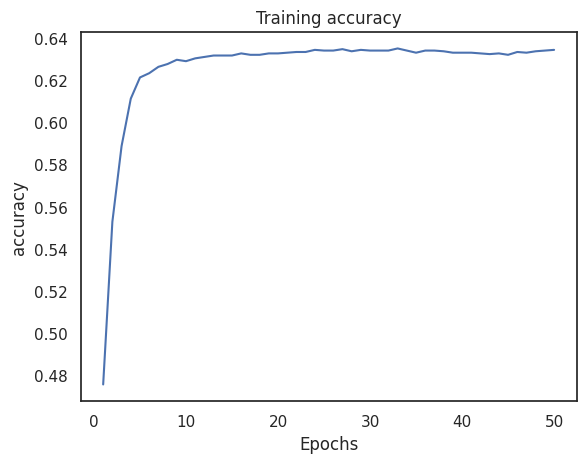

94/94 [==============================] - 0s 1ms/step
The Validation Accuracy: 
28/28 [==============================] - 0s 1ms/step
The accuracy is: 63.0872


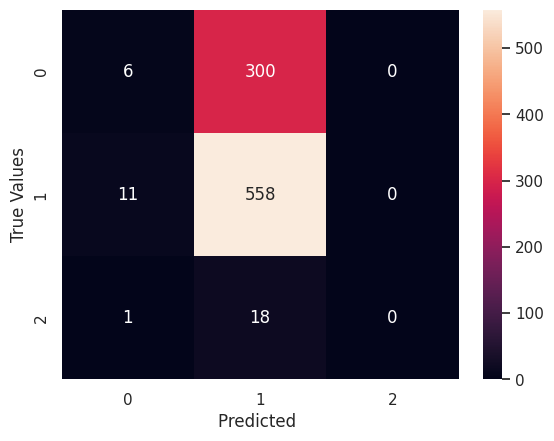

The Testing Accuracy: 
12/12 [==============================] - 0s 2ms/step
The accuracy is: 63.5417


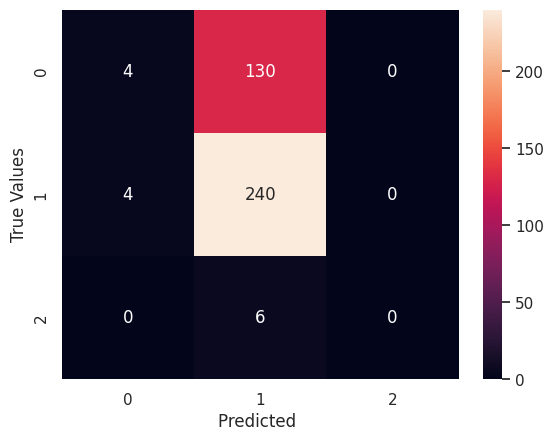

In [ ]:
simple_model = Create_Model()
history = simple_model.fit(Train_Features,
                Train_Targets,
                epochs = 50,
                batch_size = 100,
                verbose = 0)

print("The training Error and Accuracy graphs: ")
plot_metric(history, "loss",False)
plot_metric(history, "accuracy",False)
train_nn_acc = accuracy_score(Convert_Targets(Train_Targets),Convert_Targets(simple_model.predict(Train_Features)))

print("The Validation Accuracy: ")
valid_pred = simple_model.predict(Validation_Features)
valid_nn_acc = getAccuracy(valid_pred,Validation_Targets,False)

print("The Testing Accuracy: ")
test_pred = simple_model.predict(Test_Features)
test_nn_acc = getAccuracy(test_pred,Test_Targets,False)

nn_basic_table = PrettyTable(["Training Accuracy","Validation Accuracy","Testing Accuracy"])
nn_basic_table.add_row([train_nn_acc*100,valid_nn_acc*100,test_nn_acc*100])

### (3.2.2) Analysing the basic models results

### Precision-Recall curve for the validation data

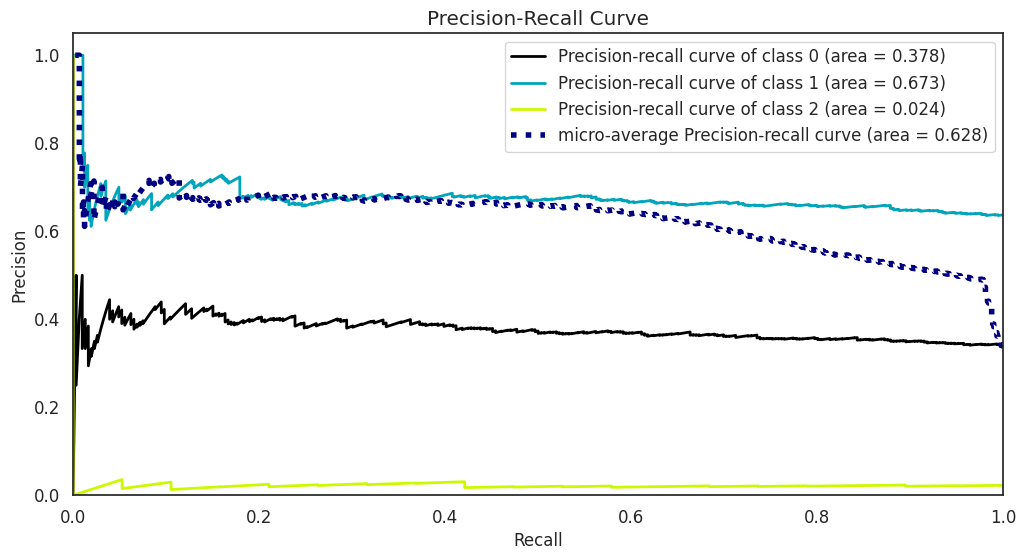

In [ ]:
skplt.metrics.plot_precision_recall_curve(Convert_Targets(Validation_Targets), valid_pred,
                       title="Precision-Recall Curve", figsize=(12,6));

### Precision-Recall curve for the testing data

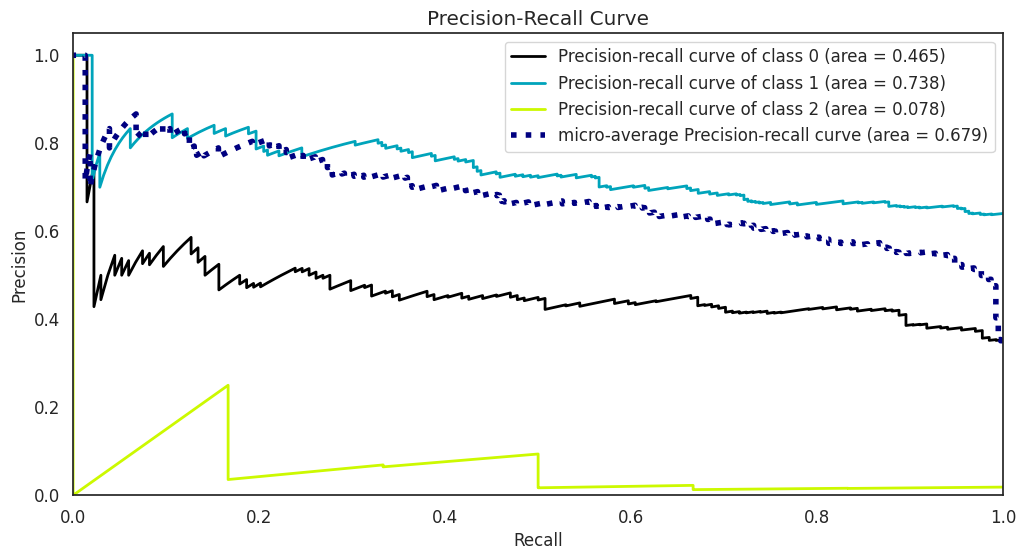

In [ ]:
skplt.metrics.plot_precision_recall_curve(Convert_Targets(Test_Targets), test_pred,
                       title="Precision-Recall Curve", figsize=(12,6));

- The area under the each line of the precision-recall curve to be high since this will indicate the model is capable of predicting the correct classes.
- However, we can clearly see that the class 1 achieves the best area under the curve, which indicates the model is good at predicting this class and predicts the other classes poorly.
- This is due to the fact that our targets are imbalanced, and 1 which represents the Red corner, which won majority of the fights.
- The lowest area is represented by class 2 which represents a draw and was the smallest represented outcome.
- The basic XGBoost classifier also has better areas than the basic NN and is better at classifying the data.

In [ ]:
print(nn_basic_table)

+-------------------+---------------------+--------------------+
| Training Accuracy | Validation Accuracy |  Testing Accuracy  |
+-------------------+---------------------+--------------------+
| 63.44735077129443 |  63.08724832214765  | 63.541666666666664 |
+-------------------+---------------------+--------------------+


### (3.2.2) Optimizing the Neural Network

- As described by Manuel Fokam, the algoirthm parameters define how you learn a model.
- In the case of Neural Networks, there a various parameters we would like to optimize:
    1. The weights initializer: The way the weight matrices are initialized.
    2. The optimizer: The algorithm used to minimize the loss function.
    3. The batch size: This decides how many data points are propagated through the network before an update is made to the weights.
    4. Epochs : The number of iterations we allow training to go on for. 
    5. The number of hidden layers
    6. The number of neurons per hidden layer
    7. The activation functions to be used within the hidden layers.

### Weights Initializers Explained:
#### 1. Glorot initialization: 
- This is the preferred method of initialization when the activation function is a Tanh or Sigmoid.
- The weights are sampled using a uniform distribution or a normal distribution.
- Using a uniform distribution, the weights are generated using the following formula:  $ W =  U[{-\sqrt\frac{6}{N_{in} + N_{out}}},\sqrt\frac{6}{N_{in} + N_{out}}]$, where $N_{in} $ represents the number of neurons from the current layer and $N_{out}$ represents the number of neurons in the layer the weights connect to.
- Using a noram distribution, the weights are generated using the following formula:  $ W =  G(0,{\sqrt\frac{6}{N_{in} + N_{out}}})$.
- Note that $\sqrt\frac{6}{N_{in} + N_{out}}$ represents the Variance.
- This ensures that the variance between weights is not large and relatively similar throughout the layers.
- By keeping the variance the same across the various layers, we are able to combat the problem of vanishing and exploding gradients which hinders learning.

#### 2. He initialization:
- This is the preferred method of initialization when the activation function is a ReLU.
- The formulae is exactly the same as Glorot, the only different is that we multiply the variance by 2.
- The reason we do this is because the ReLU turns half of the Z-values (the negative ones) into zeros, effectively removing about half of the variance. So, we need to double the variance of the weights to compensate for it.

All the above information can be found here: https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404 .

### Optimizers Explained:
#### 1. Gradient Descent:
- Gradient Descent is the most basic but most used optimization algorithm. It’s used heavily in linear regression and classification algorithms. Backpropagation in neural networks also uses a gradient descent algorithm.
- Gradient descent is a first-order optimization algorithm which is dependent on the first order derivative of a loss function.
-  It calculates that which way the weights should be altered so that the function can reach a minima. Through backpropagation, the loss is transferred from one layer to another and the model’s parameters also known as weights are modified depending on the losses so that the loss can be minimized.

#### 2. Stochastic Gradient Descent:
- It’s a variant of Gradient Descent that tries to update the model’s parameters more frequently by making an update after each point is propagated through the network.
- As the model parameters are frequently updated parameters have high variance and fluctuations in loss functions at different intensities. Thus we take steps in non-optimal directions. This leads to high variance amongst the model parameters which leads to a non-uniform convergence path to the minima.
- However since we update the weights more frequently, convergence is faster. But the caveat is that we may overshoot the minima and diverge.
- This method is preferred if the dataset is large since we don't require the entire dataset to be in RAM.
- The better alternative is called <b>Mini-Batch Gradient Descent</b>. Which propagates a smaller batch through the network before making an update to the weights.
- This combines the speed of SGD with the Uniformity of general GD.


#### 3. Adagrad:
- In most other optimizers, the learning rate is kept constant for all the weights at every epoch.
- This optimizer changes the learning rate. It changes the learning rate ‘η’ for each parameter and at every time step ‘t’. 
- It works on the derivative of an error function and also works using the second order derivative.
- η is a learning rate which is modified for given parameter θ(i) at a given time based on previous gradients calculated for given parameter θ(i).
- The update formula is as follow: $ \theta_{t+1,i} =\theta_{t,i} - \frac {η}{\sqrt{G_{t,i}+ \epsilon}}.g_{t,i} $, where $g_{t,i} = \nabla_{\theta}J(\theta_{t},i)  $.
- We store the sum of the squares of the gradients w.r.t. θ(i) up to time step t, while ϵ is a smoothing term that avoids division by zero.
- It makes big updates for less frequent parameters and a small step for frequent parameters.
- A problem with AdaGrad is that it can slow the search down too much, resulting in very small learning rates for each parameter or dimension of the search by the end of the run. This has the effect of stopping the search too soon, before the minimal can be located.

#### 4. RMSprop:
- This is an extension of Adagrad.
- In AdaGrad we take the cumulative summation of squared gradients but, in RMSP we take the 'exponential average'.
- An optimizer which uses a decaying average or moving average of the partial derivative in the calculation of the learning rate for each parameter.
- Using a decaying moving average of the partial derivative allows the search to forget early partial derivative values and focus on the most recently seen shape of the search space.
- The update formula is as follow: $ \theta_{t+1} =\theta_{t} - \frac {η}{\sqrt{V_{t}+ \epsilon}}.g_{t} $, where $V_{t} = \beta*V_{t-1} + (1- \beta)* g_{t}^2  $, where $g_{t} = \nabla_{\theta}J(\theta_{t})  $.
- Uses a moving average of squared gradients to normalize the gradient which is denoted by $g_{t}^2$.
- This normalization balances the step size (momentum), decreasing the step for large gradients to avoid exploding and increasing the step for small gradients to avoid vanishing.

#### 5. Adam:
- This optimizer is a combination of Gradient Descent with momentum and RMSprop.
- Momentum is used to accelerate the gradient descent algorithm by taking into consideration the ‘exponentially weighted average’ of the gradients. Using averages makes the algorithm converge towards the minima in a faster pace.
- By combining these two optimizations, Adam is able to converge much faster but is computationally expensive.
- The update formula is given by: $ \theta_{t+1} =\theta_{t} - \frac {η*M_{t}}{\sqrt{V_{t}+ \epsilon}}.g_{t} $, where $V_{t} = \beta_{2}*V_{t-1} + (1- \beta_{2})* g_{t}^2  $ and $M_{t} =\beta_{1}*M_{t-1} + (1- \beta_{1})* g_{t} $, where $g_{t} = \nabla_{\theta}J(\theta_{t})  $.

#### We will now perform a random search to find the optimal values for the following:
1. The initialization method to use.
2. The optimization technique to use.
3. The number of epochs to use.
4. The best batch-size to use.
5. The best activation function for the hidden layer.

Note: That the architecture for this problem is kept constant and is the simple architecture used before.<br>
The simple architecture is as follows:<br>
- A single hidden layer with 10 neurons.
- The output layer has 3 nodes and a softmax activation function.

<!-- Another Important note is that we already know that the glorot initialization performs best on the Tanh and sigmoid activation functions and that the He performs best on the ReLU. In order to save computation, this complexity is taken into account when we add layers. -->

In [ ]:
# fix random seed for reproducibility (this might work or might not work 
# depending on each library's implenentation)
seed = 7
np.random.seed(seed)
# create the sklearn model for the network
model_init_batch_epoch_CV = KerasClassifier(build_fn=Create_Model,
                                            verbose=0)

## A list of initializers we would like to choose from
init_mode = ['glorot_uniform', 'He'] 
## The batch sizes we want to consider
batches = [50,128, 512]
## The number of epochs we want to allow
epochs = [10, 20,50]
## The optimizers we want to investigate
optimizer = ["sgd","adagrad","rmsprop","adam"]
## The set of activation functions
activations = [tf.nn.leaky_relu,"sigmoid","tanh","relu"]

# grid search for initializer, batch size , number of epochs, optimizer and activation function
param_grid = dict(epochs=epochs, batch_size=batches, initalizer=init_mode, optimizer = optimizer,activation = activations)
grid = GridSearchCV(estimator=model_init_batch_epoch_CV, 
                    param_grid=param_grid,
                    cv=2)
grid_result = grid.fit(Train_Features,
                       Train_Targets,)

KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame(grid_result.cv_results_)
print("Best parameters:", grid_result.best_params_)
print("Best accuracy: ", grid_result.best_score_)

Best parameters: {'activation': 'relu', 'batch_size': 50, 'epochs': 50, 'initalizer': 'glorot_uniform', 'optimizer': 'sgd'}
Best accuracy:  0.6348088681697845


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=664729b2-75bf-4289-a3fe-9e10aaaaa8be' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>